In [2]:
import pandas as pd
import numpy as np
import keras
import keras_nlp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-02-26 14:16:14.710862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 14:16:14.710968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 14:16:14.913674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [7]:
import pandas as pd
import numpy as np
import keras
import keras_nlp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model

In [3]:
eng_df = pd.read_csv('/kaggle/input/japanese-newspapers-20052021/english_news.csv', delimiter='\t', low_memory=False)
jap_df = pd.read_csv('/kaggle/input/japanese-newspapers-20052021/japanese_news.csv', delimiter='\t', low_memory=False)

eng_df = eng_df.drop_duplicates()
jap_df = jap_df.drop_duplicates()

jap_df = jap_df.dropna(subset='text')
eng_df = eng_df.dropna(subset='text')

jap_df['lan'] = 'jap'
eng_df['lan'] = 'eng'

full_df = pd.concat([jap_df, eng_df])

del(jap_df, eng_df)


In [4]:
full_df.lan.value_counts()

lan
jap    312954
eng     35981
Name: count, dtype: int64

# Modelli

## Solo Giapponese

In [5]:
possible_labels = full_df[full_df.lan == 'jap']['source'].unique()
label_dict = {}

for index, possible_label in enumerate(possible_labels):
    
    label_dict[possible_label] = index
    
    
features = np.stack(full_df[full_df.lan == 'jap'].text)
labels = full_df[full_df.lan == 'jap'].source.map(label_dict).values

In [13]:
features_train, features_temp, labels_train, labels_temp = train_test_split(features, labels, test_size=0.4, random_state=42)

features_val, features_test, labels_val, labels_test = train_test_split(features_temp, labels_temp, test_size=0.5, random_state=42)

print("Dimensioni training:", features_train.shape, labels_train.shape)
print("Dimensioni validation:", features_val.shape, labels_val.shape)
print("Dimensioni test:", features_test.shape, labels_test.shape)

# df_train = pd.DataFrame(features_train, columns=['text'])
# df_train['label'] = labels_train
# df_train['dataset_type'] = 'train'

# df_val = pd.DataFrame(features_val, columns=['text'])
# df_val['label'] = labels_val
# df_val['dataset_type'] = 'val'

# df_test = pd.DataFrame(features_test, columns=['text'])
# df_test['label'] = labels_test
# df_test['dataset_type'] = 'test'

# pd.concat([df_train, df_val, df_test], ignore_index=True).to_csv('/kaggle/working/dataset_jap.csv')

# del(df_train, df_val, df_test)
# del(features_train, features_temp, labels_train, labels_temp, features_val, features_test, labels_val, labels_test)


Dimensioni training: (187772,) (187772,)
Dimensioni validation: (62591,) (62591,)
Dimensioni test: (62591,) (62591,)


In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/kaggle/working/model_epoca_{epoch:02d}.keras"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=False, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=4, 
                                        min_delta=0.001, 
                                        mode='min', 
                                        verbose=1) 
class_weights = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weights_dict

{0: 1.7674488652942892,
 1: 1.4014927601134497,
 2: 0.5836884789819055,
 3: 12.647134101165218,
 4: 0.5081277382237773,
 5: 0.6627769483006307,
 6: 0.33421259660326713,
 7: 1.5308207172613952,
 8: 0.5775431991683122,
 9: 0.5688716000460498,
 10: 0.6255876169820058,
 11: 10.207218960643619,
 12: 0.6967602126956915,
 13: 0.7536685611533892,
 14: 4.387401280433665,
 15: 0.41501618981312643,
 16: 42.98809523809524,
 17: 82.79188712522046,
 18: 5.70614155043,
 19: 186.28174603174602,
 20: 203.21645021645023}

In [15]:
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_multi",
    sequence_length=128,
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_multi",
    num_classes=len(label_dict),
    preprocessor=preprocessor,
)

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    jit_compile=True,
)

classifier.backbone.trainable = False



history = classifier.fit(
    x=features_train, 
    y=labels_train, 
    validation_data=(features_val, labels_val),
    batch_size=64, 
    verbose=1, 
    epochs=10, 
    callbacks=[checkpoint_callback, early_stopping_callback],
    class_weight=class_weights_dict
)

Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._func

Epoch 1/10


I0000 00:00:1708957145.498667     149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708957145.609913     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2933/2934 [============================>.] - ETA: 0s - loss: 2.6172

W0000 00:00:1708958362.013598     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2934/2934 [==============================] - ETA: 0s - loss: 2.6169

W0000 00:00:1708958470.797599     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 2.28694, saving model to /kaggle/working/model_epoca_01.keras


/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


2934/2934 [==============================] - 1369s 457ms/step - loss: 2.6169 - val_loss: 2.2869
Epoch 2/10
2934/2934 [==============================] - ETA: 0s - loss: 2.0594
Epoch 2: val_loss improved from 2.28694 to 1.93387, saving model to /kaggle/working/model_epoca_02.keras
2934/2934 [==============================] - 1321s 450ms/step - loss: 2.0594 - val_loss: 1.9339
Epoch 3/10
2934/2934 [==============================] - ETA: 0s - loss: 1.7173
Epoch 3: val_loss improved from 1.93387 to 1.80033, saving model to /kaggle/working/model_epoca_03.keras
2934/2934 [==============================] - 1320s 450ms/step - loss: 1.7173 - val_loss: 1.8003
Epoch 4/10
2934/2934 [==============================] - ETA: 0s - loss: 1.4850
Epoch 4: val_loss improved from 1.80033 to 1.70688, saving model to /kaggle/working/model_epoca_04.keras
2934/2934 [==============================] - 1320s 450ms/step - loss: 1.4850 - val_loss: 1.7069
Epoch 5/10
2934/2934 [==============================] - ETA: 0s 

KeyboardInterrupt: 

In [16]:
classifier.save('models/kaggle/model_BERT_last_epoch_JAP.keras')

   1/1956 [..............................] - ETA: 2:04:32

W0000 00:00:1708966448.968013     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1956/1956 [==============================] - 301s 152ms/step


W0000 00:00:1708966745.780465     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


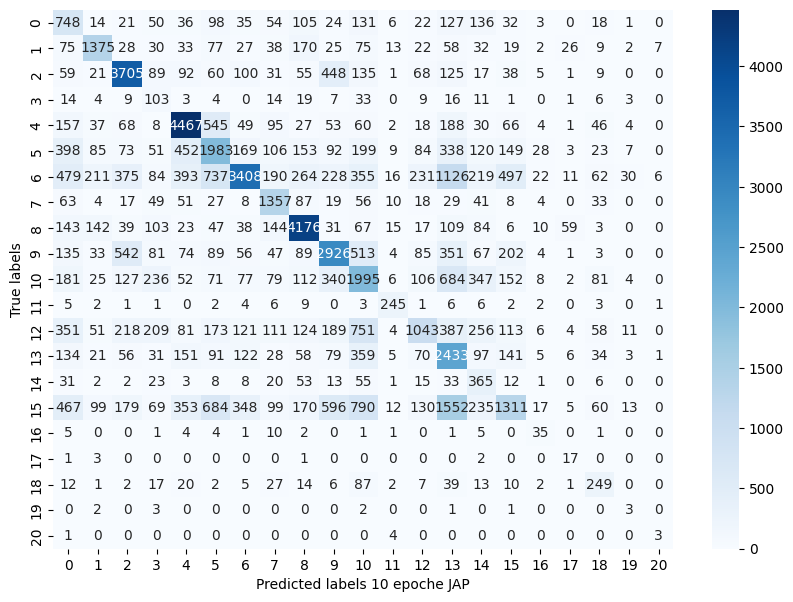

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(features_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_test, y_pred_labels)

df_cm = pd.DataFrame(cm)

plt.figure(figsize=(10, 7))

sns.heatmap(df_cm, fmt='g', annot=True, cmap="Blues")

plt.xlabel('Predicted labels 10 epoche JAP')
plt.ylabel('True labels')

plt.show()


In [18]:
label_dict

{'kobe-np.co.jp': 0,
 'hokkaido-np.co.jp': 1,
 'nikkansports.com': 2,
 'iwate-np.co.jp': 3,
 'nikkei.com': 4,
 'yomiuri.co.jp': 5,
 'mainichi.jp': 6,
 'shimotsuke.co.jp': 7,
 'tomamin.co.jp': 8,
 'sanspo.com': 9,
 'oita-press.co.jp': 10,
 'isenp.co.jp': 11,
 'nishinippon.co.jp': 12,
 'asahi.com': 13,
 'kyoto-np.co.jp': 14,
 'sankei.jp.msn.com': 15,
 'nnn.co.jp': 16,
 'tokachi.co.jp': 17,
 'yamagata-np.jp': 18,
 'chunichi.co.jp': 19,
 'tokyo-np.co.jp': 20}

## Multi lingue

In [8]:
df_full = pd.read_csv('/kaggle/input/ds-full/dataset_full.csv')
df_full.columns

Index(['Unnamed: 0', 'text', 'label', 'dataset_type'], dtype='object')

In [14]:
label_dict_multi = df_full['label'].unique()
features_train_multi = df_full[df_full.dataset_type == 'train']['text'].values
features_val_multi = df_full[df_full.dataset_type == 'val']['text'].values
features_test_multi = df_full[df_full.dataset_type == 'test']['text'].values

labels_train_multi = df_full[df_full.dataset_type == 'train']['label'].values
labels_val_multi = df_full[df_full.dataset_type == 'val']['label'].values
labels_test_multi = df_full[df_full.dataset_type == 'test']['label'].values

In [15]:
print('train: ', features_train_multi.shape, labels_train_multi.shape)
print('val: ', features_val_multi.shape, labels_val_multi.shape)
print('test: ', features_test_multi.shape, labels_test_multi.shape)

train:  (209361,) (209361,)
val:  (69787,) (69787,)
test:  (69787,) (69787,)


In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/kaggle/working/model_epoca_{epoch:02d}_multi.keras"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=False, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=4, 
                                        min_delta=0.001, 
                                        mode='min', 
                                        verbose=1) 


In [19]:
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_multi",
    sequence_length=128,
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_multi",
    num_classes=len(label_dict_multi),
    preprocessor=preprocessor,
)

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    jit_compile=True,
)

classifier.backbone.trainable = False


Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._func

In [ ]:
history = classifier.fit(
    x=features_train_multi, 
    y=labels_train_multi, 
    validation_data=(features_val_multi, labels_val_multi),
    batch_size=64, 
    verbose=1, 
    epochs=15, 
    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/15


I0000 00:00:1708773405.316126     427 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708773405.426162     427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3272/3272 [==============================] - ETA: 0s - loss: 1.6035

W0000 00:00:1708774741.457863     430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708774859.827906     427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.30852, saving model to /kaggle/working/model_epoca_01_multi.keras


/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


3272/3272 [==============================] - 1498s 449ms/step - loss: 1.6035 - val_loss: 1.3085
Epoch 2/15
3272/3272 [==============================] - ETA: 0s - loss: 1.2561
Epoch 2: val_loss improved from 1.30852 to 1.18296, saving model to /kaggle/working/model_epoca_02_multi.keras
3272/3272 [==============================] - 1484s 454ms/step - loss: 1.2561 - val_loss: 1.1830
Epoch 3/15
3272/3272 [==============================] - ETA: 0s - loss: 1.1301
Epoch 3: val_loss improved from 1.18296 to 1.12985, saving model to /kaggle/working/model_epoca_03_multi.keras
3272/3272 [==============================] - 1451s 443ms/step - loss: 1.1301 - val_loss: 1.1299
Epoch 4/15
3272/3272 [==============================] - ETA: 0s - loss: 1.0431
Epoch 4: val_loss improved from 1.12985 to 1.09937, saving model to /kaggle/working/model_epoca_04_multi.keras
3272/3272 [==============================] - 1447s 442ms/step - loss: 1.0431 - val_loss: 1.0994
Epoch 5/15
3272/3272 [========================

In [26]:
classifier.save('models/kaggle/model_BERT_MULTI.keras')

/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: 

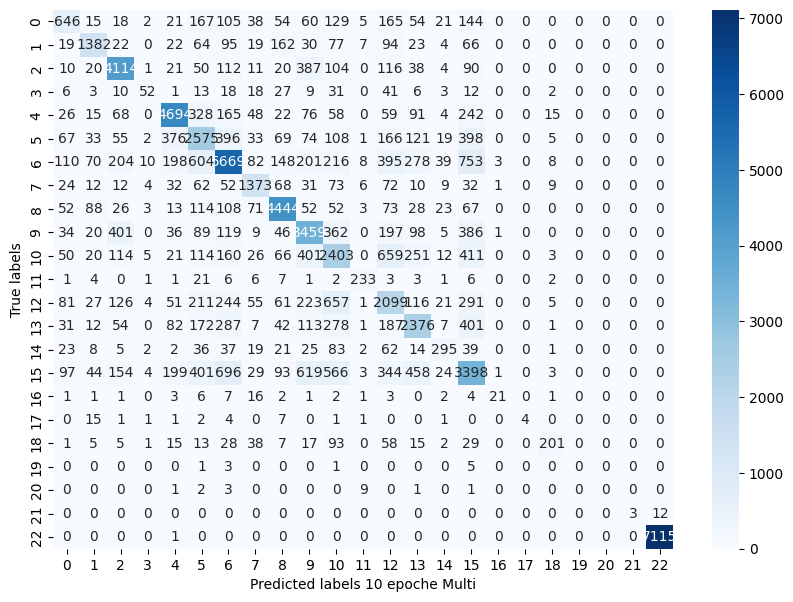

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(features_test_multi)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_test_multi, y_pred_labels)

df_cm = pd.DataFrame(cm)

plt.figure(figsize=(10, 7))

sns.heatmap(df_cm, fmt='g', annot=True, cmap="Blues")

plt.xlabel('Predicted labels 10 epoche Multi')
plt.ylabel('True labels')

plt.show()


In [33]:
possible_labels = full_df['source'].unique()
label_dict = {}

for index, possible_label in enumerate(possible_labels):
    
    label_dict[possible_label] = index

In [34]:
label_dict

{'kobe-np.co.jp': 0,
 'hokkaido-np.co.jp': 1,
 'nikkansports.com': 2,
 'iwate-np.co.jp': 3,
 'nikkei.com': 4,
 'yomiuri.co.jp': 5,
 'mainichi.jp': 6,
 'shimotsuke.co.jp': 7,
 'tomamin.co.jp': 8,
 'sanspo.com': 9,
 'oita-press.co.jp': 10,
 'isenp.co.jp': 11,
 'nishinippon.co.jp': 12,
 'asahi.com': 13,
 'kyoto-np.co.jp': 14,
 'sankei.jp.msn.com': 15,
 'nnn.co.jp': 16,
 'tokachi.co.jp': 17,
 'yamagata-np.jp': 18,
 'chunichi.co.jp': 19,
 'tokyo-np.co.jp': 20,
 'Mainichi Shimbun': 21,
 'The Japan Times': 22}

# Rete con Embedding Multilingue

In [6]:
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/multilingual/versions/2")

Attaching model 'google/universal-sentence-encoder/tensorflow2/multilingual/2' to your Kaggle notebook...


In [7]:
full_df.source.nunique()

23

In [15]:
full_df.source.value_counts()

source
mainichi.jp          44656
sankei.jp.msn.com    35959
The Japan Times      35907
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22472
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
Mainichi Shimbun        74
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: count, dtype: int64

In [8]:
X = full_df['text'].values
y = full_df['source'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [16]:
class UniversalSentenceEncoderLayer(Layer):
    def __init__(self, **kwargs):
        super(UniversalSentenceEncoderLayer, self).__init__(**kwargs)
        self.encoder = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/multilingual/versions/2")
    
    def call(self, inputs):

        reshaped_inputs = tf.squeeze(tf.cast(inputs, tf.string), axis=1)
        return self.encoder(reshaped_inputs)

input_text = Input(shape=(1,), dtype=tf.string)
encoder_layer = UniversalSentenceEncoderLayer()(input_text)
dense_layer = Dense(128, activation='relu')(encoder_layer)
output = Dense(full_df.source.nunique(), activation='softmax')(dense_layer)

model = Model(inputs=input_text, outputs=output)

def f1_score_metric(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'), (y_true, y_pred), tf.float64)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score_metric])
model.summary()


Attaching model 'google/universal-sentence-encoder/tensorflow2/multilingual/2' to your Kaggle notebook...


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 universal_sentence_encoder  (None, 512)               0         
 _layer_2 (UniversalSentenc                                      
 eEncoderLayer)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 23)                2967      
                                                                 
Total params: 68631 (268.09 KB)
Trainable params: 68631 (268.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint_callback = ModelCheckpoint(filepath='/kaggle/working/best_model.h5', 
                                      monitor='val_loss', 
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                      verbose=1)

y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

history = model.fit(X_train, y_train_one_hot, 
                    validation_data=(X_val, y_val_one_hot), 
                    epochs=100, 
                    batch_size=64, 
                    callbacks=[early_stopping, checkpoint_callback],
                    verbose=1,
                   class_weight=class_weights_dict)


Epoch 1/100
4360/4362 [============================>.] - ETA: 0s - loss: 2.3461 - f1_score_metric: 0.3430
Epoch 1: val_loss improved from inf to 2.13795, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 111s 24ms/step - loss: 2.3458 - f1_score_metric: 0.3430 - val_loss: 2.1380 - val_f1_score_metric: 0.3752
Epoch 2/100
   7/4362 [..............................] - ETA: 1:31 - loss: 2.0125 - f1_score_metric: 0.3493

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4361/4362 [============================>.] - ETA: 0s - loss: 1.9684 - f1_score_metric: 0.3954
Epoch 2: val_loss improved from 2.13795 to 2.13782, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.9684 - f1_score_metric: 0.3954 - val_loss: 2.1378 - val_f1_score_metric: 0.3830
Epoch 3/100
   7/4362 [..............................] - ETA: 1:30 - loss: 1.8428 - f1_score_metric: 0.4015

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4361/4362 [============================>.] - ETA: 0s - loss: 1.8464 - f1_score_metric: 0.4105
Epoch 3: val_loss improved from 2.13782 to 1.97871, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 100s 23ms/step - loss: 1.8464 - f1_score_metric: 0.4105 - val_loss: 1.9787 - val_f1_score_metric: 0.4094
Epoch 4/100
   7/4362 [..............................] - ETA: 1:31 - loss: 1.6685 - f1_score_metric: 0.4164

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4362/4362 [==============================] - ETA: 0s - loss: 1.7605 - f1_score_metric: 0.4196
Epoch 4: val_loss improved from 1.97871 to 1.97164, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 102s 23ms/step - loss: 1.7605 - f1_score_metric: 0.4196 - val_loss: 1.9716 - val_f1_score_metric: 0.4186
Epoch 5/100
   6/4362 [..............................] - ETA: 1:49 - loss: 1.7842 - f1_score_metric: 0.4299

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4361/4362 [============================>.] - ETA: 0s - loss: 1.6910 - f1_score_metric: 0.4262
Epoch 5: val_loss improved from 1.97164 to 1.96400, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 102s 23ms/step - loss: 1.6910 - f1_score_metric: 0.4262 - val_loss: 1.9640 - val_f1_score_metric: 0.4198
Epoch 6/100
   7/4362 [..............................] - ETA: 1:27 - loss: 1.5622 - f1_score_metric: 0.3969

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4361/4362 [============================>.] - ETA: 0s - loss: 1.6371 - f1_score_metric: 0.4310
Epoch 6: val_loss improved from 1.96400 to 1.92754, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.6370 - f1_score_metric: 0.4311 - val_loss: 1.9275 - val_f1_score_metric: 0.4254
Epoch 7/100
   7/4362 [..............................] - ETA: 1:30 - loss: 1.5438 - f1_score_metric: 0.4696

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4360/4362 [============================>.] - ETA: 0s - loss: 1.5950 - f1_score_metric: 0.4367
Epoch 7: val_loss improved from 1.92754 to 1.89939, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.5949 - f1_score_metric: 0.4367 - val_loss: 1.8994 - val_f1_score_metric: 0.4301
Epoch 8/100
   7/4362 [..............................] - ETA: 1:30 - loss: 1.4074 - f1_score_metric: 0.4706

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4362/4362 [==============================] - ETA: 0s - loss: 1.5526 - f1_score_metric: 0.4402
Epoch 8: val_loss improved from 1.89939 to 1.89670, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.5526 - f1_score_metric: 0.4402 - val_loss: 1.8967 - val_f1_score_metric: 0.4294
Epoch 9/100
   7/4362 [..............................] - ETA: 1:30 - loss: 1.2221 - f1_score_metric: 0.5013

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4360/4362 [============================>.] - ETA: 0s - loss: 1.5146 - f1_score_metric: 0.4435
Epoch 9: val_loss improved from 1.89670 to 1.86611, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.5146 - f1_score_metric: 0.4435 - val_loss: 1.8661 - val_f1_score_metric: 0.4351
Epoch 10/100
   7/4362 [..............................] - ETA: 1:33 - loss: 1.3048 - f1_score_metric: 0.4747

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4360/4362 [============================>.] - ETA: 0s - loss: 1.4923 - f1_score_metric: 0.4472
Epoch 10: val_loss did not improve from 1.86611
4362/4362 [==============================] - 101s 23ms/step - loss: 1.4923 - f1_score_metric: 0.4472 - val_loss: 1.8770 - val_f1_score_metric: 0.4320
Epoch 11/100
4360/4362 [============================>.] - ETA: 0s - loss: 1.4532 - f1_score_metric: 0.4504
Epoch 11: val_loss improved from 1.86611 to 1.84413, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.4532 - f1_score_metric: 0.4504 - val_loss: 1.8441 - val_f1_score_metric: 0.4375
Epoch 12/100
   7/4362 [..............................] - ETA: 1:30 - loss: 1.2900 - f1_score_metric: 0.4571

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4361/4362 [============================>.] - ETA: 0s - loss: 1.4236 - f1_score_metric: 0.4537
Epoch 12: val_loss did not improve from 1.84413
4362/4362 [==============================] - 100s 23ms/step - loss: 1.4236 - f1_score_metric: 0.4537 - val_loss: 1.8583 - val_f1_score_metric: 0.4384
Epoch 13/100
4360/4362 [============================>.] - ETA: 0s - loss: 1.4111 - f1_score_metric: 0.4565
Epoch 13: val_loss improved from 1.84413 to 1.80577, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.4112 - f1_score_metric: 0.4564 - val_loss: 1.8058 - val_f1_score_metric: 0.4461
Epoch 14/100
   7/4362 [..............................] - ETA: 1:30 - loss: 1.3373 - f1_score_metric: 0.4465

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4360/4362 [============================>.] - ETA: 0s - loss: 1.3757 - f1_score_metric: 0.4601
Epoch 14: val_loss did not improve from 1.80577
4362/4362 [==============================] - 101s 23ms/step - loss: 1.3758 - f1_score_metric: 0.4601 - val_loss: 1.8384 - val_f1_score_metric: 0.4394
Epoch 15/100
4360/4362 [============================>.] - ETA: 0s - loss: 1.3603 - f1_score_metric: 0.4621
Epoch 15: val_loss did not improve from 1.80577
4362/4362 [==============================] - 101s 23ms/step - loss: 1.3605 - f1_score_metric: 0.4620 - val_loss: 1.8492 - val_f1_score_metric: 0.4389
Epoch 16/100
4360/4362 [============================>.] - ETA: 0s - loss: 1.3411 - f1_score_metric: 0.4641
Epoch 16: val_loss improved from 1.80577 to 1.80265, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.3412 - f1_score_metric: 0.4641 - val_loss: 1.8027 - val_f1_score_metric: 0.4457
Epoch 17/100
   7/4362 [.......................

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4361/4362 [============================>.] - ETA: 0s - loss: 1.3235 - f1_score_metric: 0.4657
Epoch 17: val_loss did not improve from 1.80265
4362/4362 [==============================] - 101s 23ms/step - loss: 1.3235 - f1_score_metric: 0.4657 - val_loss: 1.8637 - val_f1_score_metric: 0.4377
Epoch 18/100
4361/4362 [============================>.] - ETA: 0s - loss: 1.3037 - f1_score_metric: 0.4677
Epoch 18: val_loss improved from 1.80265 to 1.79651, saving model to /kaggle/working/best_model.h5
4362/4362 [==============================] - 101s 23ms/step - loss: 1.3036 - f1_score_metric: 0.4677 - val_loss: 1.7965 - val_f1_score_metric: 0.4474
Epoch 19/100
   7/4362 [..............................] - ETA: 1:31 - loss: 1.1914 - f1_score_metric: 0.5022

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4362/4362 [==============================] - ETA: 0s - loss: 1.2927 - f1_score_metric: 0.4696
Epoch 19: val_loss did not improve from 1.79651
4362/4362 [==============================] - 101s 23ms/step - loss: 1.2927 - f1_score_metric: 0.4696 - val_loss: 1.8293 - val_f1_score_metric: 0.4413
Epoch 20/100
4362/4362 [==============================] - ETA: 0s - loss: 1.2742 - f1_score_metric: 0.4712
Epoch 20: val_loss did not improve from 1.79651
4362/4362 [==============================] - 101s 23ms/step - loss: 1.2742 - f1_score_metric: 0.4712 - val_loss: 1.7993 - val_f1_score_metric: 0.4462
Epoch 21/100
4360/4362 [============================>.] - ETA: 0s - loss: 1.2608 - f1_score_metric: 0.4722
Epoch 21: val_loss did not improve from 1.79651
4362/4362 [==============================] - 101s 23ms/step - loss: 1.2608 - f1_score_metric: 0.4722 - val_loss: 1.8442 - val_f1_score_metric: 0.4364


In [18]:
{i: label_encoder.inverse_transform([i]) for i in range(23)}

{0: array(['Mainichi Shimbun'], dtype=object),
 1: array(['The Japan Times'], dtype=object),
 2: array(['asahi.com'], dtype=object),
 3: array(['chunichi.co.jp'], dtype=object),
 4: array(['hokkaido-np.co.jp'], dtype=object),
 5: array(['isenp.co.jp'], dtype=object),
 6: array(['iwate-np.co.jp'], dtype=object),
 7: array(['kobe-np.co.jp'], dtype=object),
 8: array(['kyoto-np.co.jp'], dtype=object),
 9: array(['mainichi.jp'], dtype=object),
 10: array(['nikkansports.com'], dtype=object),
 11: array(['nikkei.com'], dtype=object),
 12: array(['nishinippon.co.jp'], dtype=object),
 13: array(['nnn.co.jp'], dtype=object),
 14: array(['oita-press.co.jp'], dtype=object),
 15: array(['sankei.jp.msn.com'], dtype=object),
 16: array(['sanspo.com'], dtype=object),
 17: array(['shimotsuke.co.jp'], dtype=object),
 18: array(['tokachi.co.jp'], dtype=object),
 19: array(['tokyo-np.co.jp'], dtype=object),
 20: array(['tomamin.co.jp'], dtype=object),
 21: array(['yamagata-np.jp'], dtype=object),
 22: ar

In [19]:
model_path = 'models/kaggle/rete_Dense_Encoder.keras'

model.save(model_path)

1091/1091 [==============================] - 14s 12ms/step


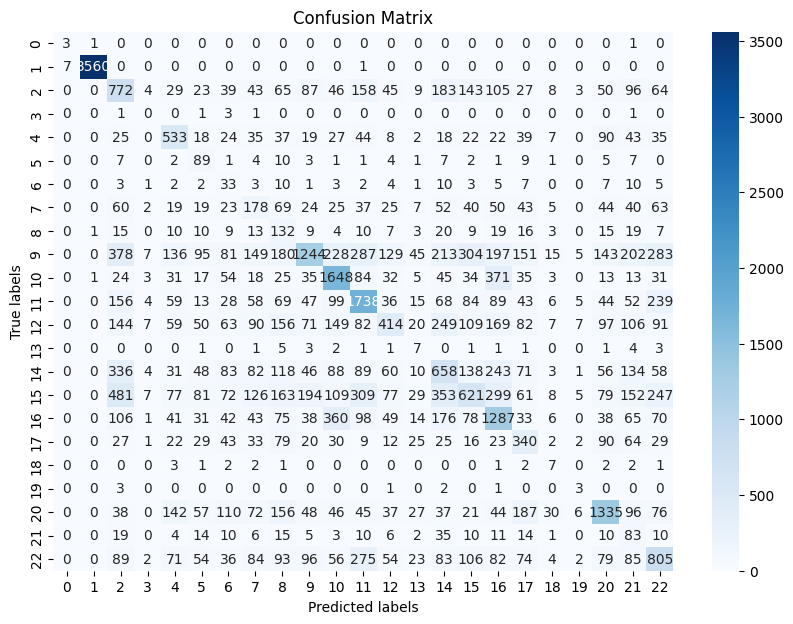

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predici le etichette sul set di test
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred_labels)

# Crea un DataFrame per la matrice di confusione
df_cm = pd.DataFrame(cm)

# Visualizza la matrice di confusione utilizzando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, fmt='g', annot=True, cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
